# FIAP Bootcamp - Wtec Suprimentos - Segmentação de Clientes
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 2: Agrupamento da Base de Clientes
- A empresa gostaria de saber se é possivel tracar alguma estratégia comum para cada grupo de cliente, no entanto essa anälise nunca foi feita e ninguém, até o momento, sabe ao certo qual seria a melhor forma de conseguir realizar esse tipo de anälise. Hoje, no conjunto de dados, näo existem informacöes claras relativas ao segmento do cliente ou tamanho, apenas dados relativos ao faturamento, ano de fundacäo, endividamento e etc.
- Isso ajudaria muito os times de marketing e anélise de crédito;

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado para agrupar os clientes em diferentes perfis
- Será utilizado um algoritmo não-supervisionado para essa classificação
- Os grupos identificados serão analisados posteriormente e qualificados

### Setup

In [1]:
# dados
import pandas as pd
import pandas_flavor as pf
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# preprocessamento
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import IsolationForest
# machine learning
from sklearn.cluster import KMeans, Birch, SpectralClustering, AgglomerativeClustering, BisectingKMeans
# seleção de modelos
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from umap import UMAP
# display
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.display.float_format = '{:,.2f}'.format

### Carga de Dados

In [2]:
data = pd.read_csv('solicitacoescredito.csv')
data.sample(10).T

,7744,1219,8061,1936,4109,931,342,3648,7830,6522
numero_solicitacao,7817,1254,8134,2005,4182,957,355,3721,7903,6595
razaoSocial,Damien O'Brien,Nathan Dodd,Connor Curtis-Morrison,Scott Phillips-Williams,Beverley Mason-Simpson,Wayne Turner-Adams,Sara Foster,Raymond Williams,Dr. Joel Scott,Mathew Mitchell
nomeFantasia,Julie Foster,Declan Richardson-Jones,Marion Perry,Katie Bailey,Janet Parkinson,Mr. Paul Chapman,Dean Price,Rebecca Hall,Trevor Thompson-Graham,Graham Collins-Pugh
cnpjSemTraco,QDXX81451812411437,FADP04355810692811,YWNX90859329600550,XQVI95337896363484,JOBA24652045791438,QICR43039981816187,IFOK15843566708440,VVYD56253498242851,WQGR61841788383763,TPAP99152822865357
maiorAtraso,2,8,0,99,53,0,64,4,2,22
margemBrutaAcumulada,0.63,0.00,0.54,0.00,0.36,0.42,0.43,0.38,0.61,0.25
percentualProtestos,0.00,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00
primeiraCompra,2018-10-29T00:00:00,2014-06-30T11:49:20,2020-05-19T00:00:00,2006-03-14T08:16:26,2006-05-29T00:00:00,2019-04-10T00:00:00,2006-07-07T00:00:00,2018-10-16T00:00:00,2015-09-16T00:00:00,2017-12-12T00:00:00
prazoMedioRecebimentoVendas,38,0,0,0,51,0,64,0,0,42
titulosEmAberto,"14,068.36",0.00,0.00,0.00,"1,985,132.91",0.00,"1,276,462.66",0.00,0.00,"21,113.39"


### Pre-Processamento

#### filtro

In [3]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame, # dataframe com a coluna 'status'
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"7,201.00","4,562.63","2,601.48",1.00,"2,353.00","4,585.00","6,827.00","9,034.00"
maiorAtraso,"7,201.00",24.37,64.03,0.00,3.00,6.00,22.00,977.00
margemBrutaAcumulada,"7,201.00",0.37,0.20,0.00,0.29,0.41,0.51,1.00
percentualProtestos,"6,057.00",0.01,0.56,0.00,0.00,0.00,0.00,36.98
prazoMedioRecebimentoVendas,"7,201.00",24.19,71.06,0.00,0.00,0.00,32.00,"1,605.00"
titulosEmAberto,"7,201.00","61,165.54","216,805.22",0.00,0.00,0.00,"18,605.30","2,836,656.00"
valorSolicitado,"7,201.00","480,475.47","15,912,896.04","3,000.00","25,000.00","50,000.00","130,000.00","1,200,000,000.00"
diferencaPercentualRisco,"7,201.00",0.74,0.13,0.26,0.64,0.75,0.85,1.00
percentualRisco,"7,201.00",0.26,0.13,0.00,0.15,0.25,0.36,0.74
dashboardCorrelacao,"7,201.00",0.04,0.50,-1.00,0.00,0.00,0.00,1.00


#### imputação

In [4]:
# preenche os valores vazios nas colunas de documentação com a média dos valores da empresa (por CNPJ)
@pf.register_dataframe_method
def impute(
		data: pd.DataFrame, # dataframe com as colunas 'cnpjSemTraco' e 'totalPatrimonioLiquido'
		) -> pd.DataFrame:
	X = data.copy()
	X['totalPatrimonioLiquido'] = X.groupby('cnpjSemTraco')['totalPatrimonioLiquido'].transform(lambda x: x.fillna(x.mean()))
	X['ativoCirculante'] = X.groupby('cnpjSemTraco')['ativoCirculante'].transform(lambda x: x.fillna(x.mean()))
	X['passivoCirculante'] = X.groupby('cnpjSemTraco')['passivoCirculante'].transform(lambda x: x.fillna(x.mean()))
	X['totalAtivo'] = X.groupby('cnpjSemTraco')['totalAtivo'].transform(lambda x: x.fillna(x.mean()))
	X['endividamento'] = X.groupby('cnpjSemTraco')['endividamento'].transform(lambda x: x.fillna(x.mean()))
	X['duplicatasAReceber'] = X.groupby('cnpjSemTraco')['duplicatasAReceber'].transform(lambda x: x.fillna(x.mean()))
	X['estoque'] = X.groupby('cnpjSemTraco')['estoque'].transform(lambda x: x.fillna(x.mean()))
	return X
data.filter_status().impute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           7201 non-null   int64  
 1   razaoSocial                  7201 non-null   object 
 2   nomeFantasia                 7201 non-null   object 
 3   cnpjSemTraco                 7201 non-null   object 
 4   maiorAtraso                  7201 non-null   int64  
 5   margemBrutaAcumulada         7201 non-null   float64
 6   percentualProtestos          6057 non-null   float64
 7   primeiraCompra               7159 non-null   object 
 8   prazoMedioRecebimentoVendas  7201 non-null   int64  
 9   titulosEmAberto              7201 non-null   float64
 10  valorSolicitado              7201 non-null   float64
 11  status                       7201 non-null   object 
 12  definicaoRisco               7201 non-null   object 
 13  diferencaPercentua

#### feature engineering

In [5]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	# converte a coluna 'dataAprovadoNivelAnalista' para datetime
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	# calcula a diferença em dias entre a data da primeira compra e a data de aprovação do nível analista
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

# gera as features calculadas usando as colunas de documentação
@pf.register_dataframe_method
def engineer_financial(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['liquidez_corrente'] = (X.ativoCirculante / X.passivoCirculante).replace([np.inf, np.NINF], np.nan)
	X['liquidez_geral'] = ((X.ativoCirculante + X.duplicatasAReceber) / (X.passivoCirculante + X.endividamento)).replace([np.inf, np.NINF], np.nan)
	X['endividamento_sobre_pl'] = (X.endividamento / X.totalPatrimonioLiquido).replace([np.inf, np.NINF], np.nan)
	X['endividamento_geral'] = ((X.endividamento + X.passivoCirculante) / X.totalAtivo).replace([np.inf, np.NINF], np.nan)
	X['prazo_medio_cobranca'] = ((X.duplicatasAReceber) / (X.faturamentoMensal) * 12 ).replace([np.inf, np.NINF], np.nan)
	return X

data.filter_status().impute().engineer().engineer_financial().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            7201 non-null   int64         
 1   razaoSocial                   7201 non-null   object        
 2   nomeFantasia                  7201 non-null   object        
 3   cnpjSemTraco                  7201 non-null   object        
 4   maiorAtraso                   7201 non-null   int64         
 5   margemBrutaAcumulada          7201 non-null   float64       
 6   percentualProtestos           6057 non-null   float64       
 7   primeiraCompra                7159 non-null   object        
 8   prazoMedioRecebimentoVendas   7201 non-null   int64         
 9   titulosEmAberto               7201 non-null   float64       
 10  valorSolicitado               7201 non-null   float64       
 11  status                        

#### seleção de features

In [6]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	keep = [
			# 'percentualRisco',
			# 'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			'faturamentoMensal',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			# 'liquidez_geral',
			# 'endividamento_sobre_pl',
			# 'endividamento_geral',
			'margem_percentual',
			'maiorAtraso',
			'prazo_medio_cobranca',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'titulosEmAberto',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return data[intersection]
data.filter_status().impute().engineer().engineer_financial().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scorePontualidade            7201 non-null   float64
 1   maiorAtraso                  7201 non-null   int64  
 2   anoFundacao                  7201 non-null   float64
 3   prazo_medio_cobranca         5013 non-null   float64
 4   titulosEmAberto              7201 non-null   float64
 5   faturamentoMensal            7201 non-null   float64
 6   prazoMedioRecebimentoVendas  7201 non-null   int64  
 7   margem_percentual            7201 non-null   float64
 8   tempoPrimeiraCompra          6631 non-null   float64
 9   restricoes                   7201 non-null   object 
 10  empresa_MeEppMei             7201 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 675.1+ KB


#### data types

In [7]:
# converte data types
@pf.register_dataframe_method
def type_cast(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.astype('float32')
data.filter_status().impute().engineer().engineer_financial().select().type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scorePontualidade            7201 non-null   float32
 1   maiorAtraso                  7201 non-null   float32
 2   anoFundacao                  7201 non-null   float32
 3   prazo_medio_cobranca         5013 non-null   float32
 4   titulosEmAberto              7201 non-null   float32
 5   faturamentoMensal            7201 non-null   float32
 6   prazoMedioRecebimentoVendas  7201 non-null   float32
 7   margem_percentual            7201 non-null   float32
 8   tempoPrimeiraCompra          6631 non-null   float32
 9   restricoes                   7201 non-null   float32
 10  empresa_MeEppMei             7201 non-null   float32
dtypes: float32(11)
memory usage: 365.7 KB


#### limpeza

In [8]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().impute().engineer().engineer_financial().select().type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scorePontualidade            4555 non-null   float32
 1   maiorAtraso                  4555 non-null   float32
 2   anoFundacao                  4555 non-null   float32
 3   prazo_medio_cobranca         4555 non-null   float32
 4   titulosEmAberto              4555 non-null   float32
 5   faturamentoMensal            4555 non-null   float32
 6   prazoMedioRecebimentoVendas  4555 non-null   float32
 7   margem_percentual            4555 non-null   float32
 8   tempoPrimeiraCompra          4555 non-null   float32
 9   restricoes                   4555 non-null   float32
 10  empresa_MeEppMei             4555 non-null   float32
dtypes: float32(11)
memory usage: 231.3 KB


#### padronização

In [9]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = StandardScaler()
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().impute().engineer().engineer_financial().select().type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
scorePontualidade,"4,555.00",0.00,1.00,-2.33,0.29,0.50,0.50,0.50
maiorAtraso,"4,555.00",-0.00,1.00,-0.55,-0.48,-0.37,0.01,5.99
anoFundacao,"4,555.00",-0.00,1.00,-3.53,-0.51,0.20,0.74,1.18
prazo_medio_cobranca,"4,555.00",-0.00,1.00,-0.65,-0.64,-0.27,0.09,5.87
titulosEmAberto,"4,555.00",0.00,1.00,-0.38,-0.38,-0.36,-0.19,5.82
faturamentoMensal,"4,555.00",-0.00,1.00,-0.29,-0.28,-0.25,-0.14,7.44
prazoMedioRecebimentoVendas,"4,555.00",-0.00,1.00,-0.57,-0.57,-0.57,0.29,5.08
margem_percentual,"4,555.00",0.00,1.00,-1.22,-1.15,0.04,0.59,2.65
tempoPrimeiraCompra,"4,555.00",-0.00,1.00,-1.22,-0.81,-0.30,0.64,2.23
restricoes,"4,555.00",-0.00,1.00,-0.26,-0.26,-0.26,-0.26,3.84


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
foi utilizada a tecnica de clip para reduzir a distorção causada pelos outliers e evitar a geração de grupos marginais na clusterização
</td></tr></table></div>

#### remoção de outliers

In [10]:
# @pf.register_dataframe_method
# def remove_outliers(
#         data: pd.DataFrame,
#     ) -> pd.DataFrame:    
#     X = data.copy()
#     # treina um modelo de Isolation Forest
#     model_if = IsolationForest(contamination=0.05).fit(X)    
#     # obtem os outliers
#     X['outlier'] = model_if.predict(X) == -1
#     X = X[X['outlier'] == False]
#     X = X.drop(columns = ['outlier'])
#     return X
# d = data.filter_status().impute().engineer().engineer_financial().select().type_cast().clean()
# print (f'Outliers removidos: {d.shape[0] - d.remove_outliers().shape[0]}')

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
- serão estudados dois cenários, utilizando ou descartando as colunas de métricas financeiras derivadas do balanço patrimonial<br>
- para cada cenário, serão testados 5 algoritmos diferentes de clusterização<br>
- será testado o intervalo de 2 a 10 grupos para cada modelo<br>
- ao total serão realizados 90 experimentos
</td></tr></table></div>

### Hipótese 1: Descartando as métricas de Balanço Patrimonial

neste cenário, ficam disponíveis mais registros para alimentar o modelo, porém a quantidade de features é reduzida

#### preprocessamento

In [11]:
data_preprocess_1 = data.filter_status().engineer().select().type_cast().clean().copy()#.remove_outliers()
data_train_1 = data_preprocess_1.standardize().copy()
data_train_1.describe().T

,count,mean,std,min,25%,50%,75%,max
scorePontualidade,"6,631.00",-0.00,1.00,-2.29,0.29,0.50,0.50,0.50
maiorAtraso,"6,631.00",0.00,1.00,-0.52,-0.44,-0.37,-0.01,6.22
anoFundacao,"6,631.00",0.00,1.00,-3.41,-0.57,0.26,0.81,1.18
titulosEmAberto,"6,631.00",0.00,1.00,-0.33,-0.33,-0.33,-0.21,5.96
faturamentoMensal,"6,631.00",-0.00,1.00,-0.28,-0.27,-0.25,-0.16,7.90
prazoMedioRecebimentoVendas,"6,631.00",-0.00,1.00,-0.51,-0.51,-0.51,0.26,5.20
margem_percentual,"6,631.00",-0.00,1.00,-0.81,-0.81,-0.81,0.69,2.98
tempoPrimeiraCompra,"6,631.00",-0.00,1.00,-1.19,-0.78,-0.31,0.59,2.43
restricoes,"6,631.00",0.00,1.00,-0.24,-0.24,-0.24,-0.24,4.10
empresa_MeEppMei,"6,631.00",0.00,1.00,-0.78,-0.78,-0.78,1.29,1.29


#### espaço de busca

In [12]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
models = [
  ('KMeans', KMeans(init='k-means++', n_init=10)),
  ('Birch', Birch()),
  ('Spectral', SpectralClustering(affinity='nearest_neighbors')),
  ('Agglomerative', AgglomerativeClustering(linkage='ward')),
  ('BisectingKMeans', BisectingKMeans(init='k-means++', bisecting_strategy='biggest_inertia'))
]

#### grid search

In [13]:
results_1 = []
pbar = tqdm(total=len(models)*len(n_clusters), desc='realizando o grid search', unit='model', position=0, leave=False, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', ncols=100)
for name, model in models:
	for n in n_clusters:
		model.set_params(n_clusters=n)
		model.fit(data_train_1)
		results_1.append({
			'model': name,
			'n_clusters': n,
			'inertia': model.inertia_ if hasattr(model, 'inertia_') else None, # lower is better
			'silhouette': silhouette_score(data_train_1, model.labels_), # higher is better
			'similarity': davies_bouldin_score(data_train_1, model.labels_), # lower is better
			'variance_ratio': calinski_harabasz_score(data_train_1, model.labels_), # higher is better
			'labels': model.labels_, # cluster labels
		})
		pbar.update(1)

realizando o grid search: 100%|████████████████████| 45/45 [00:38<00:00,  2.04model/s]              

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
os modelos foram avaliados utilizando 3 métricas aplicáveis a modelos onde não é possível comparar a segmentação com labels conhecidos: <br>
- silhouette_score: quanto maior o score, melhor a definição dos clusters<br>
- variance_ratio (calinski_harabasz_score): quanto maior o score, melhor a definição dos clusters<br>
- similarity (davies_bouldin_score): quanto menor o score, menor a similaridade entre os clusters<br>
</td></tr></table></div>

#### avaliação dos modelos

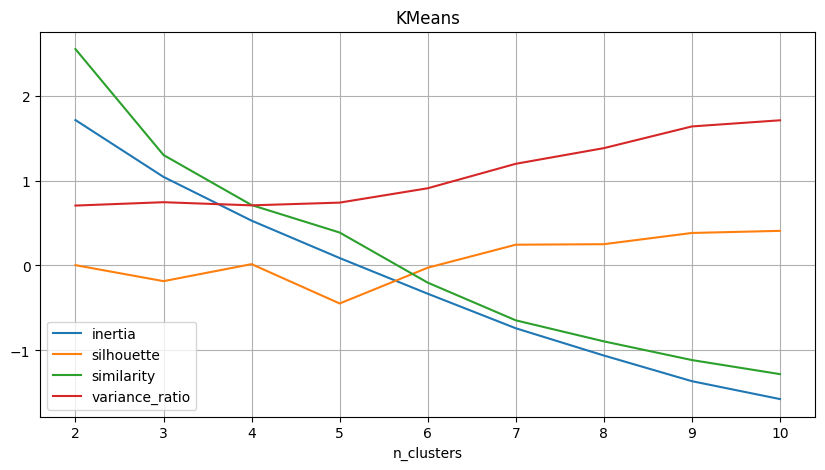

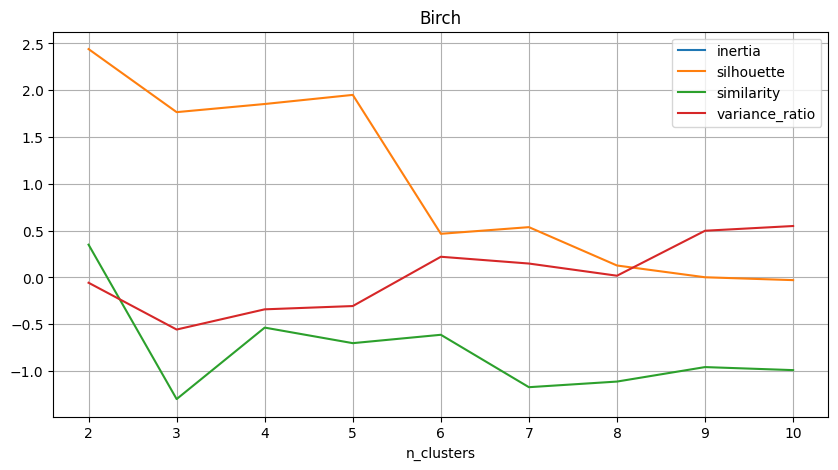

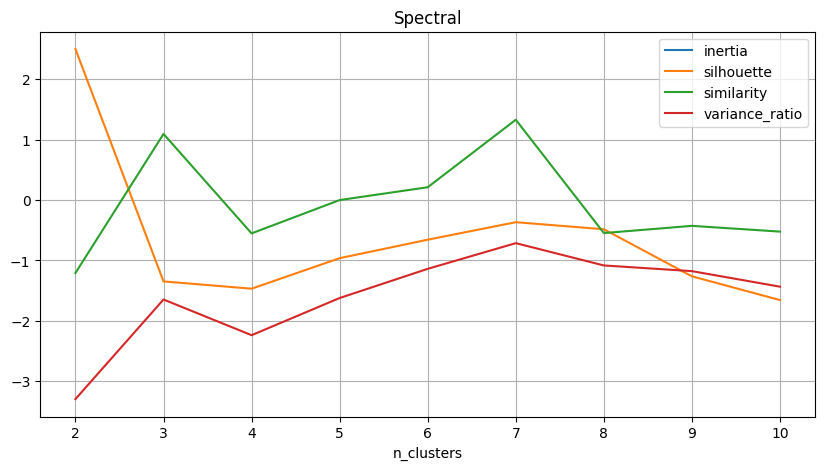

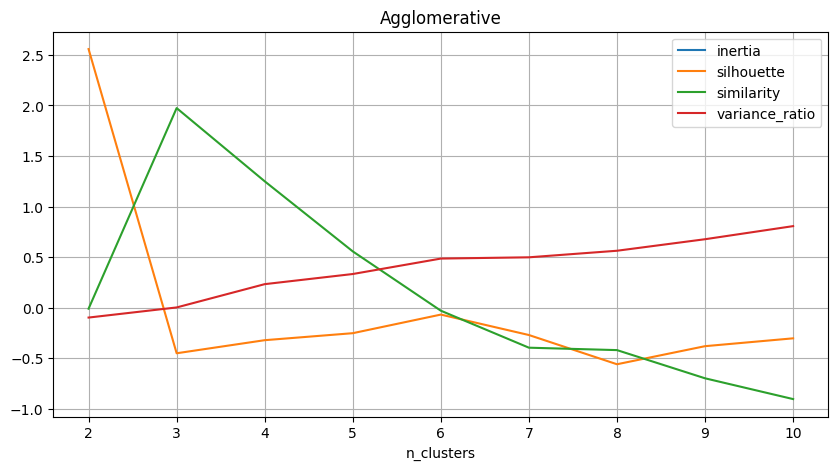

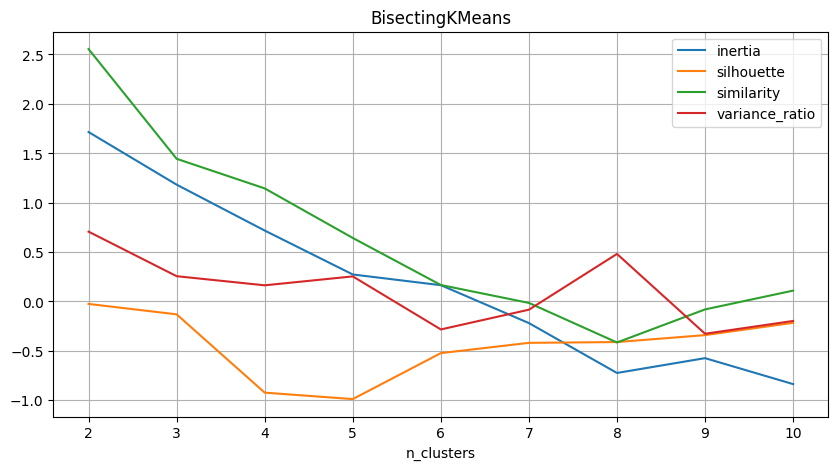

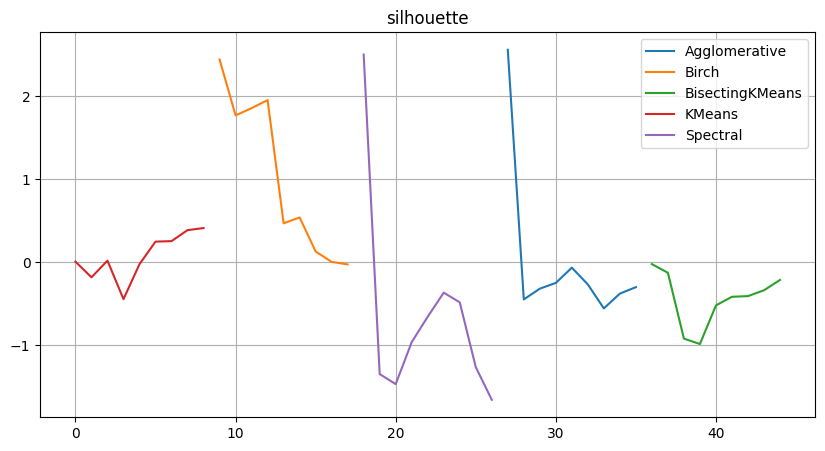

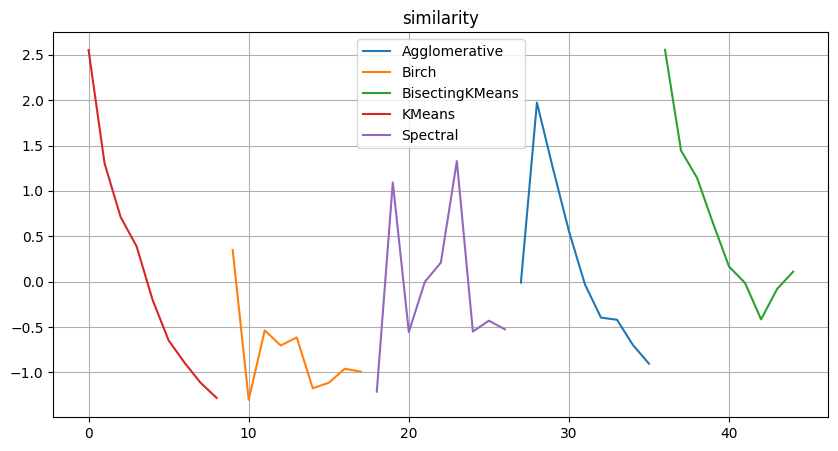

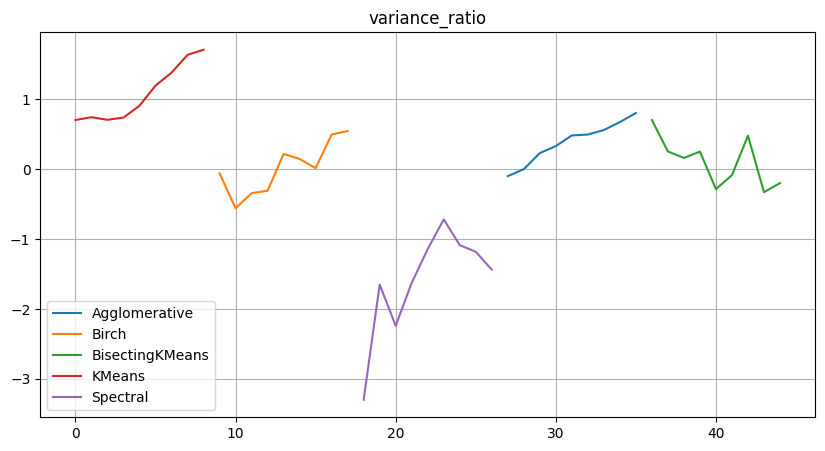

In [14]:
results_df = pd.DataFrame(results_1)
results_df = results_df.drop(columns=['labels'])
# padroniza as métricas por z-score para facilitar a visualização
results_df.silhouette = (results_df.silhouette - results_df.silhouette.mean()) / results_df.silhouette.std()
results_df.similarity = (results_df.similarity - results_df.similarity.mean()) / results_df.similarity.std()
results_df.variance_ratio = (results_df.variance_ratio - results_df.variance_ratio.mean()) / results_df.variance_ratio.std()
results_df.inertia = (results_df.inertia - results_df.inertia.mean()) / results_df.inertia.std()
for model in results_df.model.unique():
	df = results_df[results_df.model == model]
	df = df.set_index('n_clusters')
	df.plot(title=model, figsize=(10, 5), grid=True)
	plt.title(model)
	plt.show()
for metric in results_df.columns[3:]:
	results_df.groupby('model')[metric].plot(legend=True, figsize=(10, 5), grid=True, x = 'n_clusters')
	plt.title(metric)
	plt.show()

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
pela análise das métricas, entre 4 e 7 clusters parecem definir bem os grupos.<br>
para efeito de simplificação, será utilizada a separação em 6 clusters
</td></tr></table></div>

In [61]:
clusters_1 = 6

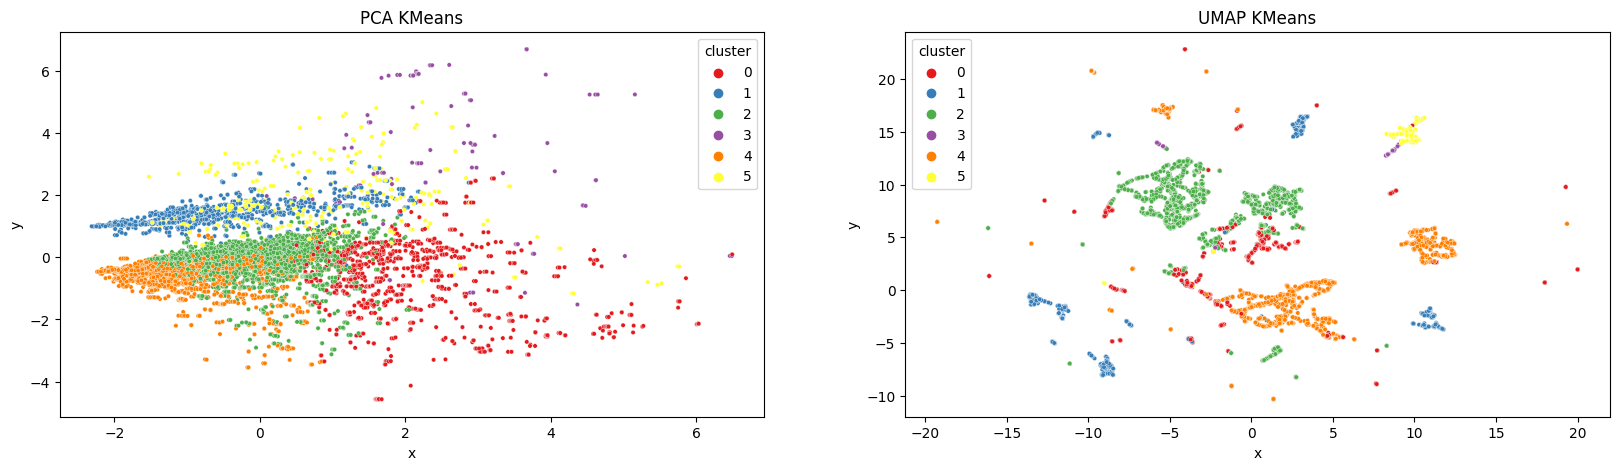

2    2473
4    1857
0     970
1     904
5     323
3     104
Name: cluster, dtype: int64


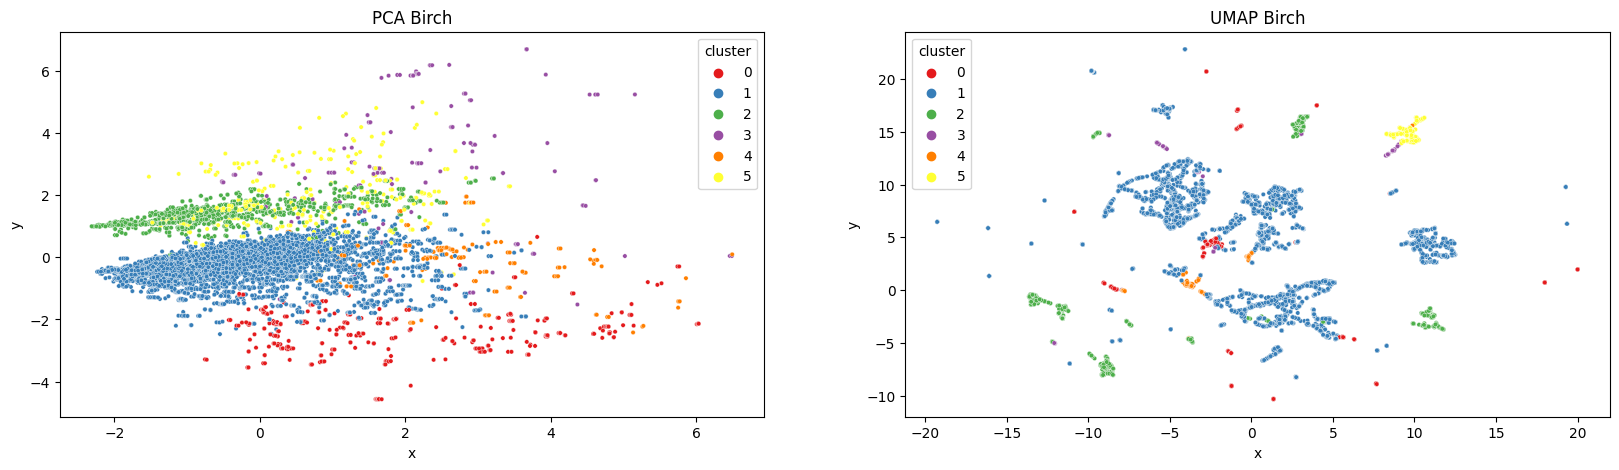

1    4765
2     909
0     354
5     304
4     154
3     145
Name: cluster, dtype: int64


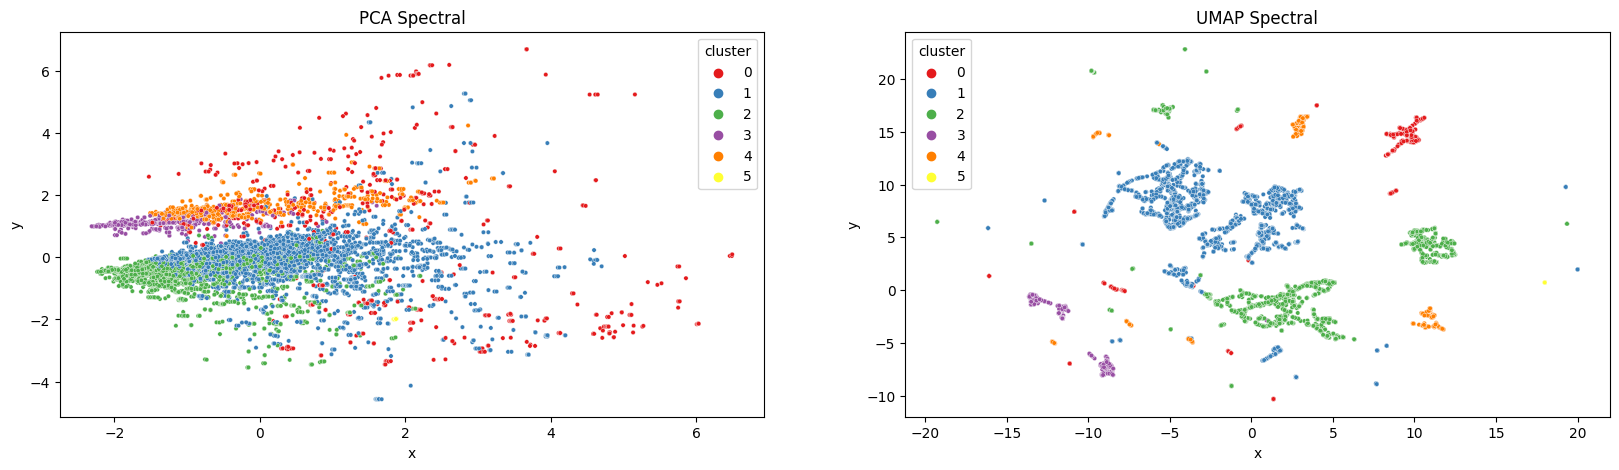

1    3166
2    1973
0     570
4     536
3     376
5      10
Name: cluster, dtype: int64


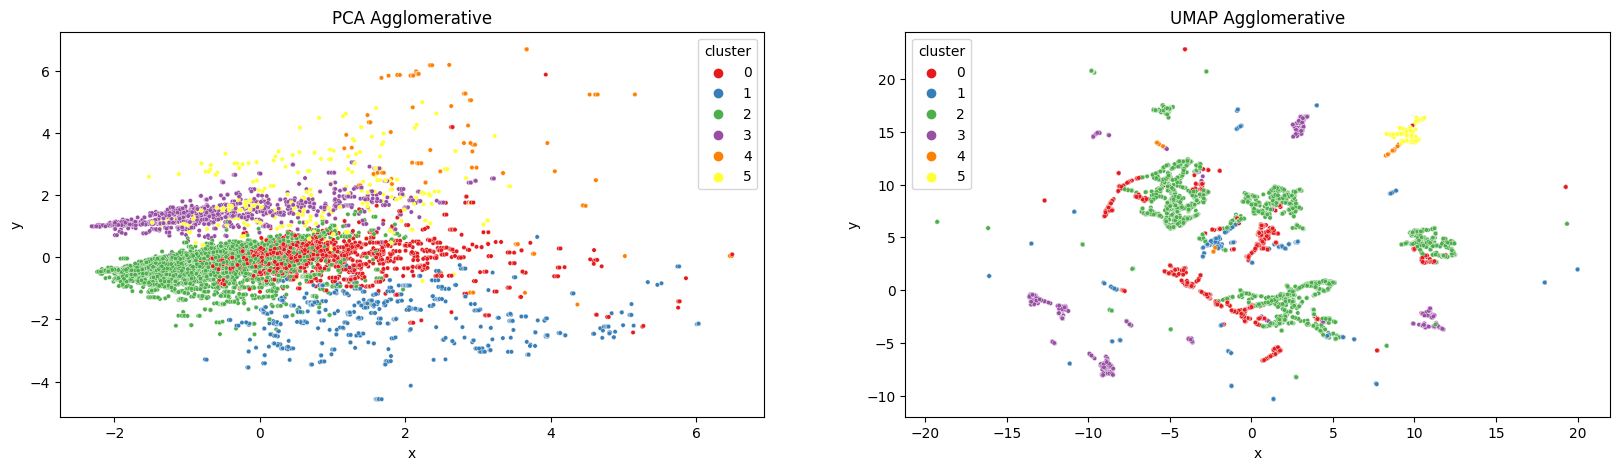

2    3391
0    1313
3     942
1     585
5     305
4      95
Name: cluster, dtype: int64


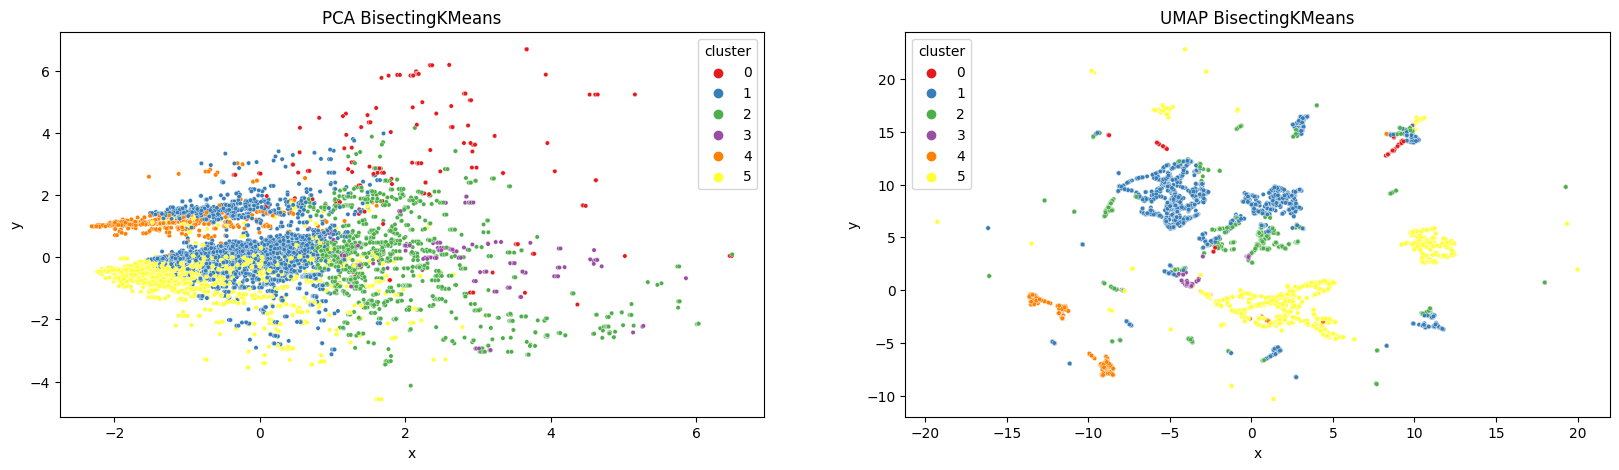

1    2758
5    2085
2    1115
4     404
0     149
3     120
Name: cluster, dtype: int64


In [62]:
reducer_1 = PCA(n_components=2)
reducer_2 = UMAP(n_components=2)
data_reduced_1 = pd.DataFrame(reducer_1.fit_transform(data_train_1), columns=['x', 'y'])
data_reduced_2 = pd.DataFrame(reducer_2.fit_transform(data_train_1), columns=['x', 'y'])

for model in results_df.model.unique():
	data_reduced_model_1 = data_reduced_1.copy()
	data_reduced_model_2 = data_reduced_2.copy()
	data_reduced_model_1['cluster'] = list(filter(lambda x: x['model'] == model and x['n_clusters'] == clusters_1, results_1))[0]['labels']
	data_reduced_model_2['cluster'] = list(filter(lambda x: x['model'] == model and x['n_clusters'] == clusters_1, results_1))[0]['labels']
	fig, ax = plt.subplots(1, 2, figsize=(20, 5))
	sns.scatterplot(data=data_reduced_model_1, x='x', y='y', hue='cluster', palette='Set1', ax=ax[0], s=10)
	ax[0].set_title(f'PCA {model}')
	sns.scatterplot(data=data_reduced_model_2, x='x', y='y', hue='cluster', palette='Set1', ax=ax[1], s=10)
	ax[1].set_title(f'UMAP {model}')
	plt.show()
	print(data_reduced_model_1.cluster.value_counts())

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
o modelo que performou melhor nesse cenário foi o KMeans
</td></tr></table></div>

In [63]:
best_model_1 = 'KMeans'

#### interpretação da segmentação

In [64]:
# obtem os labels para o melhor modelo
labels = list(filter(lambda x: x['model'] == best_model_1 and x['n_clusters'] == clusters_1, results_1))[0]['labels']
# concatena com os dados de treino (sem padronização)
data_eval_1 = data_preprocess_1.copy()
data_eval_1['cluster'] = labels
data_eval_1.cluster.value_counts()

2    2473
4    1857
0     970
1     904
5     323
3     104
Name: cluster, dtype: int64

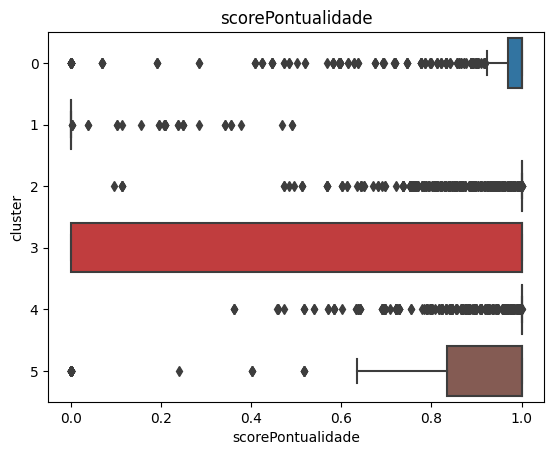

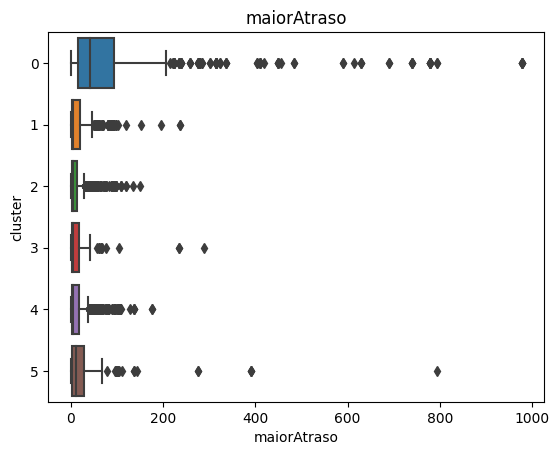

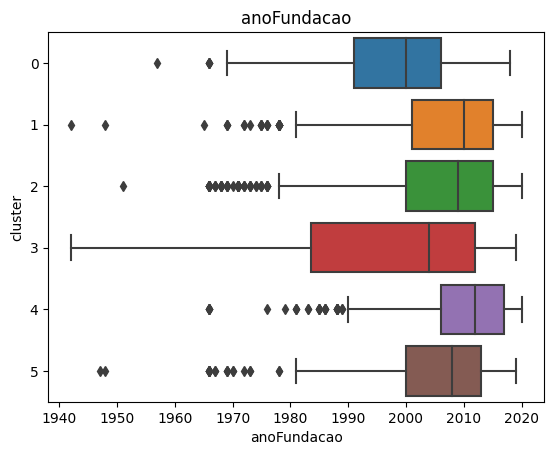

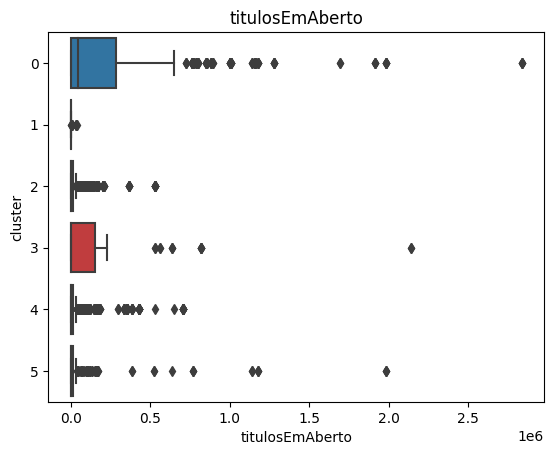

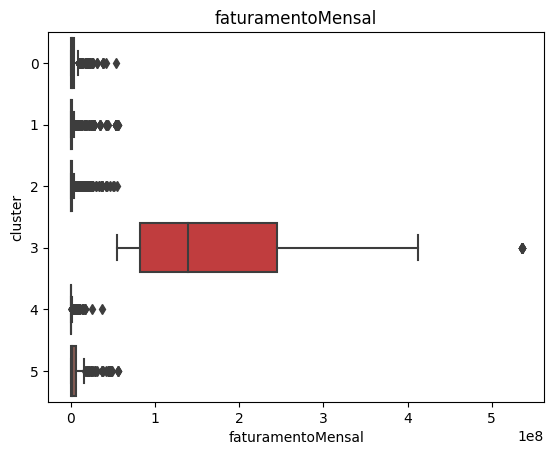

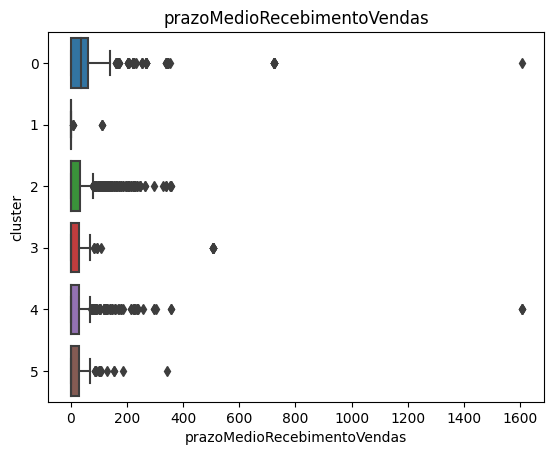

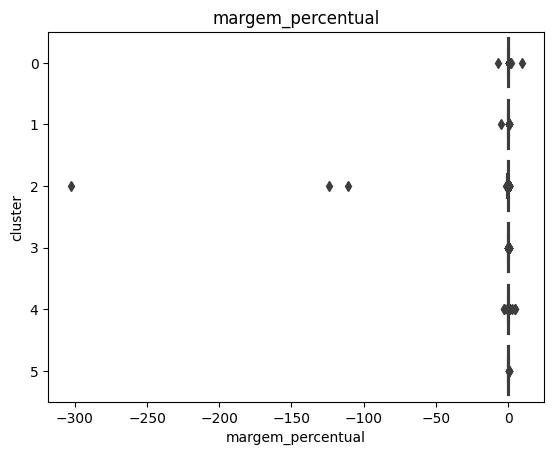

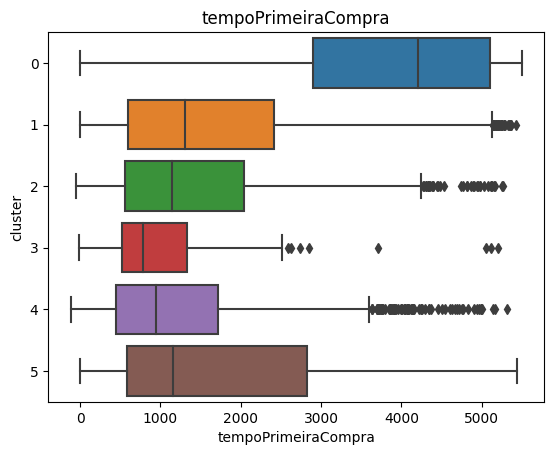

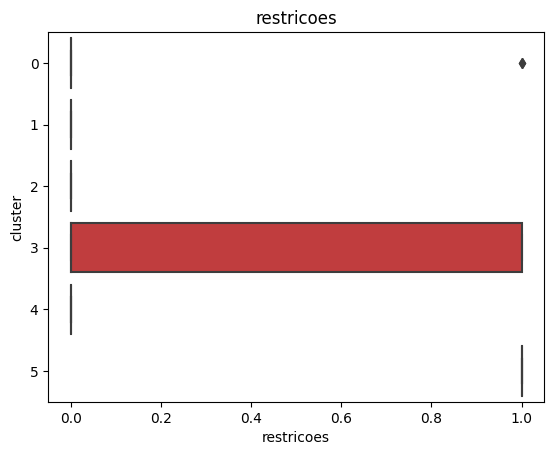

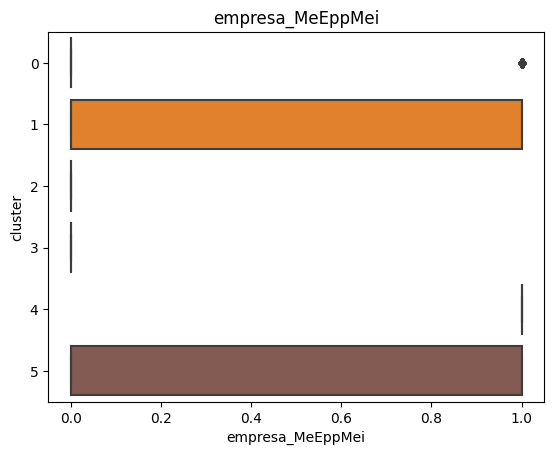

In [65]:
for feature in data_eval_1.columns:
	if feature == 'cluster':
		continue
	sns.boxplot(y='cluster', x=feature, data=data_eval_1, orient='h')
	plt.title(feature)
	plt.show()

In [66]:
# obtem os valores médios, mínimos e máximos para cada coluna por cluster
# set pandas format to 2 decimal places
data_eval_1.groupby('cluster').agg(['mean']).T

,cluster,0,1,2,3,4,5
scorePontualidade,mean,0.92,0.01,0.98,0.65,0.98,0.78
maiorAtraso,mean,86.11,16.49,10.13,22.17,12.84,27.28
anoFundacao,mean,"1,998.75","2,006.97","2,006.27","1,995.72","2,010.28","2,003.89"
titulosEmAberto,mean,"222,900.78",191.22,"17,264.76","151,975.22","26,387.96","67,798.45"
faturamentoMensal,mean,"3,382,371.25","3,249,248.25","2,043,016.38","186,316,096.00","716,426.56","6,642,698.50"
prazoMedioRecebimentoVendas,mean,55.93,0.40,20.44,56.86,21.41,17.39
margem_percentual,mean,0.34,0.20,-0.04,0.31,0.20,0.21
tempoPrimeiraCompra,mean,"3,817.11","1,689.79","1,381.74","1,098.47","1,242.33","1,760.19"
restricoes,mean,0.00,0.00,0.00,0.45,0.00,1.00
empresa_MeEppMei,mean,0.18,0.42,0.00,0.00,1.00,0.26


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
A tabela acima descreve, a grosso modo, as características de cada grupo
</td></tr></table></div>

### Persistência

#### identificação dos clusters - hipótese 1

In [67]:
# obtem os labels
labels = list(filter(lambda x: x['model'] == best_model_1 and x['n_clusters'] == clusters_1, results_1))[0]['labels']
# concatena com os dados de treino, incluindo o identificador
data_cluster1 = data.filter_status().engineer().select(identifier=True).type_cast().clean().copy()
data_cluster1['cluster1'] = labels
# transforma a coluna numero_solicitacao em index
data_cluster1 = data_cluster1.set_index('numero_solicitacao')
# seleciona apenas as colunas de interesse
data_cluster1 = data_cluster1[['cluster1']]
data_cluster1.sample(5)

,cluster1
numero_solicitacao,
"2,388.00",4
"2,018.00",0
"1,894.00",4
"2,714.00",0
998.00,4


#### persistência dos dados

In [68]:
# carrega a base de dados original
base = pd.read_csv('solicitacoescredito.csv')
# transforma a coluna numero_solicitacao em index
base = base.set_index('numero_solicitacao')
print (base.shape)
# realiza o join com as colunas de cluster
base = base.join(data_cluster1)
# base = base.join(data_cluster2)
print (base.shape)
print (base.info())
print (base.cluster1.value_counts())
# print (base.cluster2.value_counts())
# salva a base de dados com os clusters
base.to_csv('solicitacoescredito_segmentada.csv')

(8973, 37)
(8973, 38)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 8973 entries, 1.0 to 9045.0
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   razaoSocial                  8973 non-null   object 
 1   nomeFantasia                 8973 non-null   object 
 2   cnpjSemTraco                 8973 non-null   object 
 3   maiorAtraso                  8973 non-null   int64  
 4   margemBrutaAcumulada         8973 non-null   float64
 5   percentualProtestos          7475 non-null   float64
 6   primeiraCompra               8867 non-null   object 
 7   prazoMedioRecebimentoVendas  8973 non-null   int64  
 8   titulosEmAberto              8973 non-null   float64
 9   valorSolicitado              8973 non-null   float64
 10  status                       8973 non-null   object 
 11  definicaoRisco               8973 non-null   object 
 12  diferencaPercentualRisco     8973 non-null   flo

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
As segmentações foram persistidas em uma cópia da base de dados, para serem utilizadas posteriormente nos próximos modelos
</td></tr></table></div>

### Análise de Risco por Segmento

#### cenário 1

<Axes: xlabel='percentualRisco', ylabel='cluster1'>

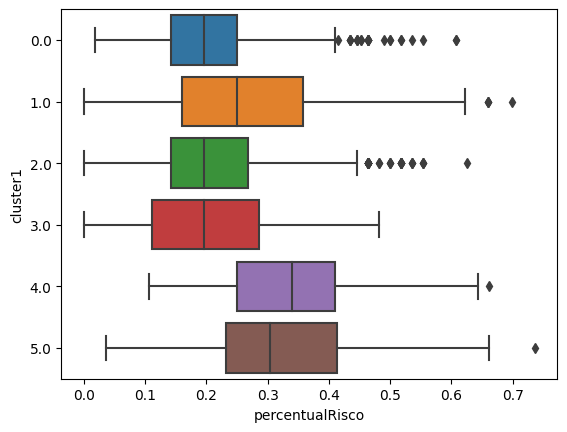

In [69]:
sns.boxplot(y='cluster1', x='percentualRisco', data=base, orient='h')

<Axes: xlabel='valorAprovado', ylabel='cluster1'>

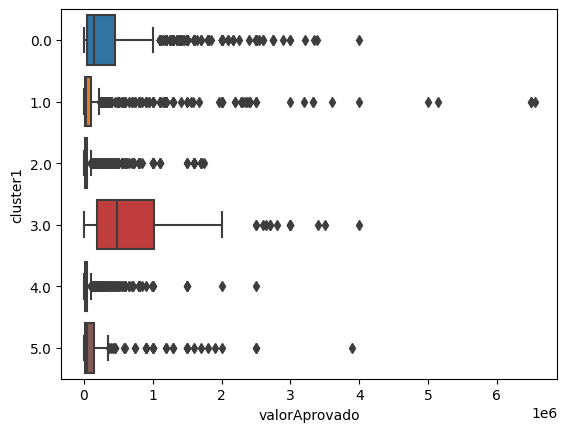

In [70]:
sns.boxplot(y='cluster1', x='valorAprovado', data=base, orient='h')

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:100px;">⭐</td><td style="border:0px;">
É possível também observar que os segmentos identificados apresentam diferentes comportamentos de risco, e diferentes faixas de valores de crédito aprovado, em ambas as hipóteses
</td></tr></table></div>